In [14]:
import torch
import torch.utils.data
from torch import nn, optim
# from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm

# from sklearn.preprocessing import LabelBinarizer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from model.core import VAE
from model.module_utils import *
from model.vae_utility import *
from dataset.loader import *
from config import *

import random as rn
from pathlib import Path

np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

In [2]:
trainx, valx, ohe = get_train_val(0.2, cols, cat_cols, preprocessing = 'log')

In [3]:
testx, testy, orig_labels= get_test(cols, cat_cols, ohe, preprocessing='log')

In [4]:
batch_size = 400

train_loader = torch.utils.data.DataLoader(trainx, batch_size=batch_size\
                                           , shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(valx, batch_size=batch_size\
                                         , shuffle=True, num_workers=8)

In [5]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [82]:
data[0].shape[0]

126

In [6]:
original_dim = trainx.shape[1]
intermediate_dim = 20
latent_dim = 4

act_fun = 'relu'
# kernel_max_norm = 1000
weight_KL_loss = 0.8

Nf_lognorm = 34
Nf_binomial = original_dim-Nf_lognorm

In [54]:
input_size = original_dim  # size of each input
hidden_size = intermediate_dim  # hidden dimension
latent_size = latent_dim # latent vector dimension

trainloader = torch.utils.data.DataLoader(trainx, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valx, batch_size=batch_size, shuffle=True)

In [49]:
vae = VAE(input_size, hidden_size
          , latent_dim, Nf_lognorm, Nf_binomial).to(device)

In [50]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [51]:
epochs = 20

In [52]:
save_model_path = Path('model_results/')
model_name = 'vae_nls_kdd.h5'
if not(save_model_path.exists()):
    print('creating path')
    os.makedirs(save_model_path)

In [60]:
"""
Set the model to the training mode first and train
"""
vae.train()
train_loss = []
val_loss = 10**16
for epoch in range(epochs):
    for i, data in enumerate(trainloader):
        data = (data.type(torch.FloatTensor)).to(device)
        optimizer.zero_grad()
        pars, mu, sigma = vae(data)

        recon_loss = loss_function(data, pars, Nf_lognorm,
                                  Nf_binomial).mean()
    
        KLD = KL_loss_forVAE(mu,sigma).mean()
        loss = recon_loss + weight_KL_loss*KLD  # the mean of KL is added to the mean of MSE
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

        if i % 10 == 0:
            print("Loss:")
#             print(loss.item()/len(images))
            print(loss.item())

# plt.plot(train_loss)
# plt.show()

    """
    Set the model to the evaluation mode. This is important otherwise you will get inconsistent results. Then load data from the test set.
    """
    vae.eval()
    vectors = []
    with torch.no_grad():
        for i, data in enumerate(valloader):
            data = (data.type(torch.FloatTensor)).to(device)
            pars, mu, sigma = vae(data)

            recon_loss = loss_function(data, pars, Nf_lognorm,
                                      Nf_binomial).mean()

            KLD = KL_loss_forVAE(mu,sigma).mean()
            loss += recon_loss + weight_KL_loss*KLD
        
        loss = loss / len(valloader)
        if loss < val_loss:
            print('val_loss improved from {} to {}, saving model to {}'\
                  .format(val_loss, loss, save_model_path))
            torch.save(vae.state_dict(), save_model_path / model_name)
            val_loss = loss

Loss:
-13.188192367553711
Loss:
-13.259650230407715
Loss:
-12.853959083557129
Loss:
-12.943358421325684
Loss:
-12.199614524841309
Loss:
-13.681341171264648
Loss:
-13.282419204711914
Loss:
-13.378366470336914
Loss:
-14.415117263793945
Loss:
-13.302459716796875
Loss:
-13.679447174072266
Loss:
-12.949419021606445
Loss:
-13.68109130859375
Loss:
-13.187186241149902
val_loss improved from 10000000000000000 to -13.254806518554688, saving model to model_results
Loss:
-13.527860641479492
Loss:
-13.29416275024414
Loss:
-12.969101905822754
Loss:
-14.226609230041504
Loss:
-12.703136444091797
Loss:
-12.999361038208008
Loss:
-13.603246688842773
Loss:
-12.522589683532715
Loss:
-13.588000297546387
Loss:
-13.205708503723145
Loss:
-13.492297172546387
Loss:
-13.312751770019531
Loss:
-13.190733909606934
Loss:
-13.272346496582031
val_loss improved from -13.254806518554688 to -13.604610443115234, saving model to model_results
Loss:
-13.916025161743164
Loss:
-13.710904121398926
Loss:
-13.735566139221191
Loss

KeyboardInterrupt: 

In [20]:
# testloader = torch.utils.data.DataLoader(valx, batch_size=1, shuffle=True)

In [61]:
testloader = torch.utils.data.DataLoader(testx, batch_size=1)

In [62]:
vae.eval()
losses_t = []
for i, data in enumerate(testloader):
    test_loss = 0
    data = (data.type(torch.FloatTensor)).to(device)
#             data = (data.to(device)).astype(np.float32)
    pars, mu, sigma = vae(data)
    recon_loss = loss_function(data, pars, Nf_lognorm, Nf_binomial).mean()

    losses_t.append(recon_loss)

In [63]:
sig_losses_t = [losses_t[i] for i in range(len(testy[:len(losses_t)])) if testy[i]==1]
bkg_losses_t = [losses_t[i] for i in range(len(testy[:len(losses_t)])) if testy[i]==0]

In [64]:
bkg_losses_n = [x.cpu().detach().clone().numpy() for x in bkg_losses_t]
sig_losses_n = [x.cpu().detach().clone().numpy() for x in sig_losses_t]

In [65]:
bkg_losses_n = [x.tolist() for x in bkg_losses_n]
sig_losses_n = [x.tolist() for x in sig_losses_n]

In [66]:
histo_start = min(losses_t).cpu().detach().clone().numpy().tolist()
histo_end = np.percentile(sig_losses_n, 90)

In [67]:
bins = 100

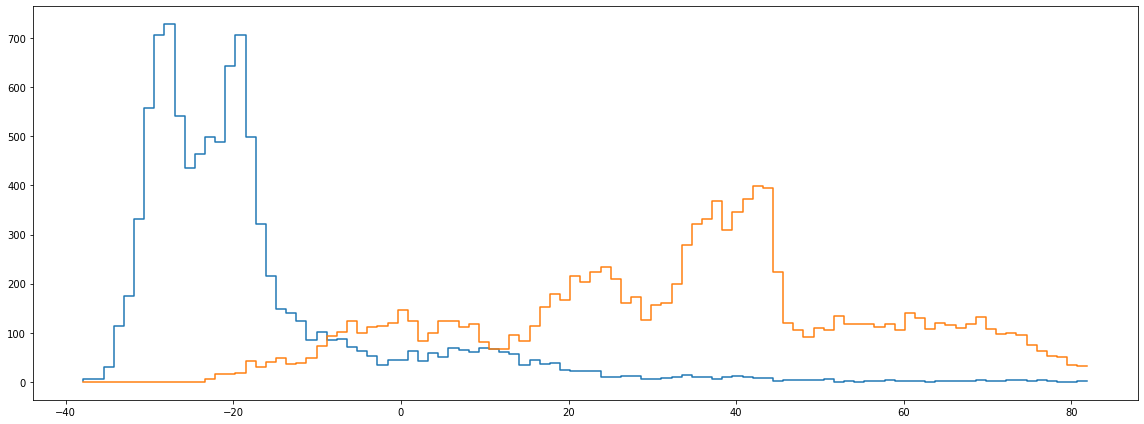

In [68]:
histo_range = (histo_start, histo_end)
f,a = plt.subplots(1,1, figsize=(16, 6))

counts_b = torch.histc(torch.Tensor(bkg_losses_t), bins = bins, min = histo_range[0]
                     , max = histo_range[1])
bin_edges_b = torch.linspace(histo_range[0], histo_range[1], steps=bins)

counts_s = torch.histc(torch.Tensor(sig_losses_t), bins = bins, min = histo_range[0]
                     , max = histo_range[1])
bin_edges_s = torch.linspace(histo_range[0], histo_range[1], steps=bins)


a.step(x=bin_edges_b, y=counts_b, label = 'bkg')
a.step(x=bin_edges_s, y=counts_s, label = 'sig')

plt.tight_layout()

In [69]:
from sklearn.metrics import f1_score, accuracy_score

In [70]:
losses_n = [x.cpu().detach().clone().numpy() for x in losses_t]

In [71]:
ths = np.linspace(histo_start, np.percentile(losses_n, 50), num = 10)

In [72]:
f1_scores = []
for th in ths:
    predicted_label = np.array([1 if x >th else 0 for x in losses_n])
    f1_scores.append(f1_score(testy, predicted_label))

0.9217819598617952


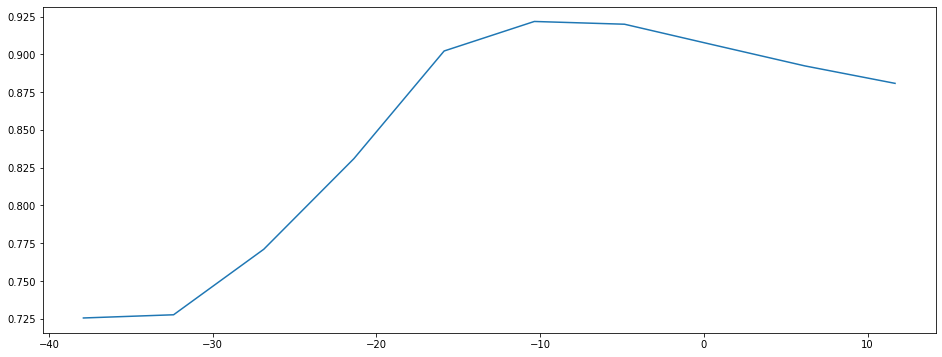

In [73]:
f,a = plt.subplots(1,1, figsize=(16, 6))
a.plot(ths,f1_scores)
print(max(f1_scores))